In [60]:
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkConf

spark = SparkSession.builder.appName("Test_spark").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

In [61]:
from google.colab import files
uploaded = files.upload()

,summary,number,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
0,count,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064
1,mean,545.0018796992481,918.9031798641051,65.02260949558733,142.30675564934037,5.48579305071369,148.48042413321315,6.999713658875691,0.18202347650615522,266.3936973996037,34.07743985327709,35.14838093290533
2,stddev,316.7961112479536,3.1790395342048496,11.168033449415704,69.14947215860062,4.534427253459236,67.15491055520599,5.590789883333875,1.534493272239725,1503.0922161525937,25.35666812000875,22.365474966763042
3,min,0,907.9900000000024,36.752000000000685,15.500000000000046,0.69345139999974,28.89999999999991,1.1855782000000479,0.0,0.0,6.090000000001012,5.3000000000006855
4,max,1094,929.3200000000012,98.90599999999992,343.4,23.554978199999763,312.19999999999993,29.84077959999996,24.01999999999907,17704.0,92.6200000000002,92.2500000000003


In [86]:
df = sqlCtx.read.load('daily_weather.csv', format='com.databricks.spark.csv', header='true', inferSchema='true', sep=",")
df = df.dropna()
df.describe().toPandas()

,summary,number,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
0,count,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064,1064
1,mean,545.0018796992481,918.9031798641051,65.02260949558733,142.30675564934037,5.48579305071369,148.48042413321315,6.999713658875691,0.18202347650615522,266.3936973996037,34.07743985327709,35.14838093290533
2,stddev,316.7961112479536,3.1790395342048496,11.168033449415704,69.14947215860062,4.534427253459236,67.15491055520599,5.590789883333875,1.534493272239725,1503.0922161525937,25.35666812000875,22.365474966763042
3,min,0,907.9900000000024,36.752000000000685,15.500000000000046,0.69345139999974,28.89999999999991,1.1855782000000479,0.0,0.0,6.090000000001012,5.3000000000006855
4,max,1094,929.3200000000012,98.90599999999992,343.4,23.554978199999763,312.19999999999993,29.84077959999996,24.01999999999907,17704.0,92.6200000000002,92.2500000000003


In [62]:
df = df.drop('number')
df.toPandas().head(20)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.00,0.0,42.420000,36.160000
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.00,0.0,24.328697,19.426597
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,0.00,20.0,8.900000,14.460000
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.00,0.0,12.189102,12.742547
4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,8.90,14730.0,92.410000,76.740000
5,915.300000,78.404000,182.800000,9.932014,189.000000,10.983375,0.02,170.0,35.130000,33.930000
6,915.598868,70.043304,177.875407,3.745587,186.606696,4.589632,0.00,0.0,10.657422,21.385657
7,918.070000,51.710000,242.400000,2.527742,271.600000,3.646212,0.00,0.0,80.470000,74.920000
8,920.080000,80.582000,40.700000,4.518619,63.000000,5.883152,0.00,0.0,29.580000,24.030000
9,915.010000,47.498000,163.100000,4.943637,195.900000,6.576604,0.00,0.0,88.600000,68.050000


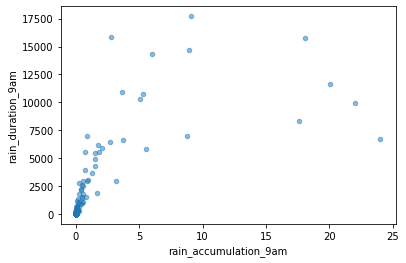

In [63]:
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

df_diagram = df.toPandas()
data = pd.concat([df_diagram['rain_accumulation_9am'], df_diagram['rain_duration_9am']], axis=1)
data.plot.scatter(x='rain_accumulation_9am', y='rain_duration_9am', alpha=0.5)

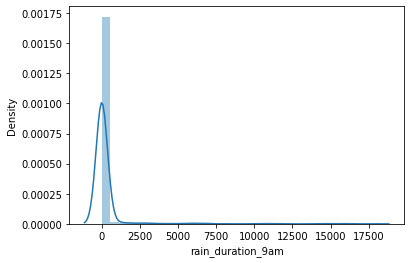

In [64]:
sns.distplot(df_diagram['rain_duration_9am'])

In [65]:
bounds = {
    c: dict(
        zip(["d1","d9"], df.approxQuantile(c, [0.1, 0.9], 0))
    )
    for c,d in zip (df.columns, df.dtypes) if d[1] == "double"
}

for c in bounds:
    iqr = bounds [c]['d9'] - bounds[c]['d1']
    bounds[c]['min'] = bounds[c]['d1'] - (iqr * 1.5)
    bounds[c]['max'] = bounds[c]['d9'] + (iqr * 1.5)

bounds

{'air_pressure_9am': {'d1': 914.9000000000107,
  'd9': 922.9900000000019,
  'max': 935.1249999999889,
  'min': 902.7650000000237},
 'air_temp_9am': {'d1': 48.61428416150457,
  'd9': 79.10599999999816,
  'max': 124.84357375773854,
  'min': 2.8767104037641857},
 'avg_wind_direction_9am': {'d1': 47.96625159478844,
  'd9': 218.50000000000009,
  'max': 474.30062260781756,
  'min': -207.834371013029},
 'avg_wind_speed_9am': {'d1': 1.5658579999999074,
  'd9': 12.298367980222027,
  'max': 28.397132950555203,
  'min': -14.53290697033327},
 'max_wind_direction_9am': {'d1': 63.638273440836045,
  'd9': 226.59999999999994,
  'max': 471.04258983874576,
  'min': -180.80431639790976},
 'max_wind_speed_9am': {'d1': 2.2369400000000708,
  'd9': 15.452305806183404,
  'max': 35.2753545154584,
  'min': -17.586108709274928},
 'rain_accumulation_9am': {'d1': 0.0,
  'd9': 0.009999999999990905,
  'max': 0.024999999999977263,
  'min': -0.014999999999986358},
 'rain_duration_9am': {'d1': 0.0,
  'd9': 67.115599720

In [66]:
import pyspark.sql.functions as f 
removeOutliers = df.select (
'air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am', 'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am', 'rain_accumulation_9am', 'rain_duration_9am', 'relative_humidity_9am', 'relative_humidity_3pm',
    *[
        f.when(
            ~f.col('rain_accumulation_9am').between(bounds['rain_accumulation_9am']['min'], bounds['rain_accumulation_9am']['max']),
            "yes"
        ).otherwise("no").alias('rain_accumulation_9am_outlier'),
        f.when(
            ~f.col('rain_duration_9am').between(bounds['rain_duration_9am']['min'], bounds['rain_duration_9am']['max']),
            "yes"
        ).otherwise("no").alias('rain_duration_9am_outlier')
    ]
)

df = removeOutliers.filter("rain_accumulation_9am_outlier = 'no'")
df = removeOutliers.filter("rain_duration_9am_outlier = 'no'")

df = df.drop("rain_accumulation_9am_outlier")
df = df.drop("rain_duration_9am_outlier")

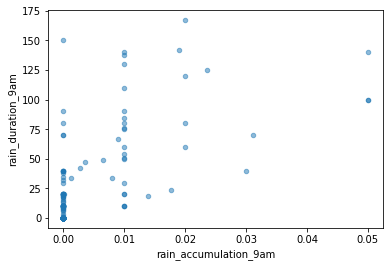

In [67]:
df_diagram = df.toPandas()
data = pd.concat([df_diagram['rain_accumulation_9am'], df_diagram['rain_duration_9am']], axis=1)
data.plot.scatter(x='rain_accumulation_9am', y='rain_duration_9am', alpha=0.5)

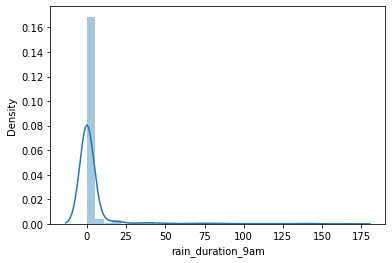

In [68]:
sns.distplot(df_diagram['rain_duration_9am'])

In [69]:
from pyspark.ml.feature import Binarizer

binarizer = Binarizer(threshold=25.00001, inputCol = 'relative_humidity_3pm', outputCol = 'label')
df = df.withColumn('relative_humidity_3pm', func.round(df['relative_humidity_3pm']).cast('double'))
df = binarizer.transform(df)

df.toPandas().head(20)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm,label
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,0.0,42.420000,36.0,1.0
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,0.0,24.328697,19.0,0.0
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,0.0,20.0,8.900000,14.0,0.0
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,0.0,12.189102,13.0,0.0
4,915.598868,70.043304,177.875407,3.745587,186.606696,4.589632,0.0,0.0,10.657422,21.0,0.0
5,918.070000,51.710000,242.400000,2.527742,271.600000,3.646212,0.0,0.0,80.470000,75.0,1.0
6,920.080000,80.582000,40.700000,4.518619,63.000000,5.883152,0.0,0.0,29.580000,24.0,0.0
7,915.010000,47.498000,163.100000,4.943637,195.900000,6.576604,0.0,0.0,88.600000,68.0,1.0
8,919.650000,77.036000,70.600000,3.825167,85.500000,4.764682,0.0,0.0,22.070000,32.0,1.0
9,917.390000,49.784000,204.100000,1.275056,211.800000,2.013246,0.0,0.0,73.150000,58.0,1.0


In [70]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
 
featureColumns = ['air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am', 'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am', 'rain_accumulation_9am', 'rain_duration_9am', 'relative_humidity_9am']
 
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
assembled = assembler.transform(df)
 
(trainingData, testData) = assembled.randomSplit([0.8,0.2], seed=13234)
trainingData.count(), testData.count()

from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5, minInstancesPerNode=20, impurity="gini")

from pyspark.ml import Pipeline
 
pipeline = Pipeline(stages=[dt])
model = pipeline.fit (trainingData)
predictions = model.transform(testData)
predictions.select("prediction", "label").show()

+----------+-----+
|prediction|label|
+----------+-----+
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
+----------+-----+
only showing top 20 rows



In [71]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy=evaluator.evaluate(predictions)
print("Accuracy = %g" %(accuracy*100))

Accuracy = 87.4372


In [77]:
featureColumns=['air_pressure_9am','avg_wind_direction_9am','avg_wind_speed_9am','max_wind_direction_9am', 'max_wind_speed_9am','rain_accumulation_9am','rain_duration_9am','relative_humidity_9am']
assembler = VectorAssembler(inputCols=featureColumns, outputCol="features")
assembled = assembler.transform(df)

In [78]:
splits = assembled.randomSplit([0.7,0.3], 111)
dfTraining = splits[0]
dfTest = splits[1]

In [79]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, regParam=0.0, solver="normal", labelCol="air_temp_9am", featuresCol="features")
lr.setRegParam(0.0)
lr.setElasticNetParam(0.0)

LinearRegression_a5d600814f50

In [80]:
LRModel = lr.fit(dfTraining)
predict_df = LRModel.transform(dfTest)

In [81]:
predict_df.select("air_temp_9am", "prediction").show()

+------------------+-----------------+
|      air_temp_9am|       prediction|
+------------------+-----------------+
| 50.71999999999946|52.42583328809792|
| 46.56199999999832|48.91106192562518|
| 59.82800000000221|57.98242223985653|
| 71.87000000000026|67.98258218943852|
| 78.33200000000203|70.71347514095146|
|52.321999999999285|55.86363085953383|
| 64.81400000000556|64.92757085848928|
| 63.37400000000071|64.14013948004413|
| 79.21400000000408|77.42945239039818|
| 68.23400000000528| 66.6519158575179|
| 68.95400000000538|71.44073662723167|
| 79.73599999999936|75.28552912959753|
| 81.75199999999823|75.89259161413429|
| 81.51024958998009|75.98144395790996|
| 74.24599999999855|74.48169452397269|
| 76.22600000000237|70.61111708741464|
| 49.44199999999925| 53.9849547014328|
| 74.40354196840171|74.22755724570425|
|48.037999999998576| 54.8146207648208|
| 84.36200000000544|70.05849140332293|
+------------------+-----------------+
only showing top 20 rows



In [84]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="air_temp_9am", metricName="r2")
print ("r2 on test data = %g" % evaluator.evaluate(predict_df))
print ("r2 on training data = %g" % evaluator.evaluate(LRModel.transform(dfTraining)))

r2 on test data = 0.552607
r2 on training data = 0.484875


In [88]:
evaluator2 = RegressionEvaluator(labelCol="air_temp_9am", metricName="rmse")
print ("rmse on test data = %g" % evaluator2.evaluate(predict_df))
print ("rmse on training data = %g" % evaluator2.evaluate(LRModel.transform(dfTraining)))

rmse on test data = 7.22062
rmse on training data = 7.45267
